In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pyplot

In [2]:
class gauss_density_estimator:
    def __init__(self,n_dims):
        self.mu = np.zeros((1,n_dims))
        self.n_dims = n_dims
        self.sigma_sq = np.ones(n_dims)
        
    def train(self, train_data):
        self.mu = np.mean(train_data, axis = 0)
        self.sigma_sq =  np.sum((train_data - self.mu) ** 2.0, axis = 0) / train_data.shape[0]
        
    def compute_predictions(self, test_data):
        c = -self.n_dims * np.log(2*np.pi)/2.0 - np.log(np.prod(self.sigma_sq))/2.0
        log_prob = c - np.sum((test_data -  self.mu)**2.0/ (2.0 * self.sigma_sq),axis=1)
        
        return log_prob

In [117]:
class parzen_estimator:
    def __init__(self,n_dims,h):
        self.n_dims = n_dims
        self.h = h
    def train(self, train_data):
        self.train_data = train_data
        
    def compute_predictions(self,x):
        #if self.n_dims == 1:
            #pdf = (1.0/self.train_data.shape[0])*(1/(np.power(np.sqrt(2*np.pi)*self.h,self.n_dims)))*np.sum(np.exp((-1)*np.power((x-self.train_data),2.)/(2*self.h**2)))
        #elif self.n_dims > 1:
        point = np.ones([self.train_data.shape[0],self.n_dims])
        #point[:,0] = x
        #point[:,1] = y
        point = x
        
        constant = (1.0/self.train_data.shape[0])*(1/(np.power(np.sqrt(2*np.pi)*self.h,self.n_dims))) #scalar
        if self.n_dims == 1:
            norm_diff = np.power(np.linalg.norm((point - self.train_data)[:,None],axis = 1),2.)
        else:
            norm_diff = np.power(np.linalg.norm((point - self.train_data),axis = 1),2.)
        prob = np.sum(constant*(np.exp((-1)*(norm_diff)/(2*self.h**2))))
        return prob

[ 0.140816  0.029556]
[ 3.428  1.462]


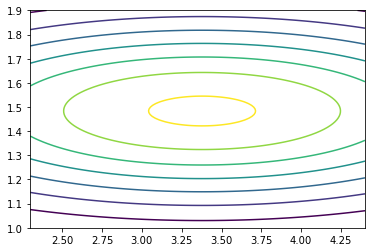

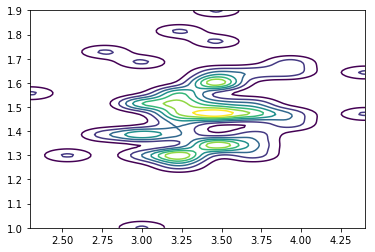

In [115]:
iris = np.loadtxt('iris.txt')
class1_2d = iris[:50,[1,2]]
x = np.linspace(np.min(class1_2d[:,0]), np.max(class1_2d[:,0]), num = 120)
y = np.linspace(np.min(class1_2d[:,1]), np.max(class1_2d[:,1]), num = 120)
Zgauss = np.zeros((x.shape[0],y.shape[0]))
gaussian_2d = gauss_density_estimator(2)
gaussian_2d.train(class1_2d)
print  gaussian_2d.sigma_sq
print gaussian_2d.mu

for i, val1 in enumerate(x):
    for j,val2 in enumerate(y):
        Zgauss[i,j] = gaussian(np.array([val1,val2]), gaussian_2d.mu, gaussian_2d.sigma_sq)
        
pyplot.contour(x,y,Zgauss)
pyplot.show()

parzen_2d = parzen_estimator(2,.05)
parzen_2d.train(class1_2d)
Z= np.zeros([120,120])
for i,val1 in enumerate(x):
    for j,val2 in enumerate(y):
        Z[i,j] = parzen_2d.compute_predictions(np.array([val1,val2]))
        
pyplot.contour(x,y,Z)
pyplot.show()

(150L, 5L)


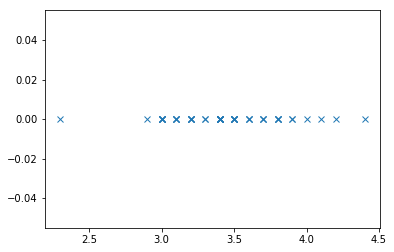

In [4]:
iris = np.loadtxt('iris.txt')
print iris.shape
class1 = iris[:50,:]
class1_1d = iris[:50,1]
pyplot.plot(class1_1d, np.zeros_like(class1_1d)+0, 'x')
pyplot.show()

(120L,)


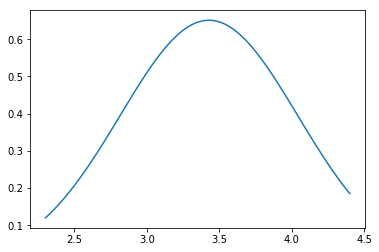

In [83]:
def gaussian(x, mu, sig_sq):
    if x.shape[0] != 2:
        return (1/np.sqrt(2*np.pi*sig_sq))*np.exp(-np.power(x - mu, 2.) / (2 * sig_sq))
    else:
        return np.product((1/(np.sqrt(2*np.pi)*np.power(sig_sq, x.shape[0]/2.0)))*(np.exp((-np.transpose(x - mu)*(x-mu)))) / (2 * sig_sq))
        

model = gauss_density_estimator(1)
model.train(class1_1d)

line = np.linspace(np.min(class1_1d), np.max(class1_1d), num=120)
print np.shape(line)
y = gaussian(line,model.mu, np.sqrt(model.sigma_sq))
pyplot.plot(line,y)


(120L,)
<type 'numpy.ndarray'>


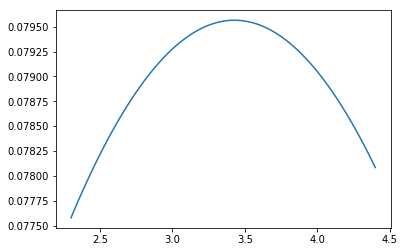

In [118]:
parzen = parzen_estimator(1,5)
parzen.train(class1_1d)
z=np.zeros(len(line))
print z.shape
for i,val in enumerate(line):
    
    z[i] = parzen.pdf(val)
print type(z)
pyplot.plot(line,z)

[ 0.140816  0.029556]
[ 3.428  1.462]


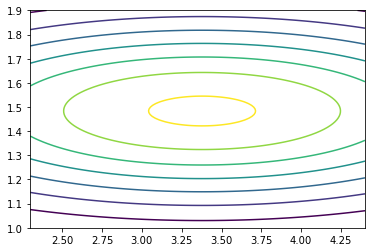

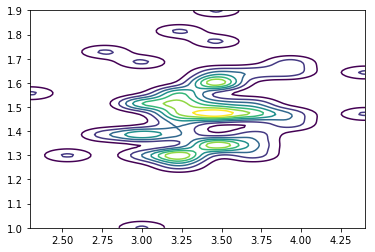

In [121]:
iris = np.loadtxt('iris.txt')
class1_2d = iris[:50,[1,2]]
x = np.linspace(np.min(class1_2d[:,0]), np.max(class1_2d[:,0]), num = 120)
y = np.linspace(np.min(class1_2d[:,1]), np.max(class1_2d[:,1]), num = 120)
Zgauss = np.zeros((x.shape[0],y.shape[0]))
gaussian_2d = gauss_density_estimator(2)
gaussian_2d.train(class1_2d)
print  gaussian_2d.sigma_sq
print gaussian_2d.mu

for i, val1 in enumerate(x):
    for j,val2 in enumerate(y):
        Zgauss[i,j] = gaussian(np.array([val1,val2]), gaussian_2d.mu, gaussian_2d.sigma_sq)
        
pyplot.contour(x,y,Zgauss)
pyplot.show()

parzen_2d = parzen_estimator(2,.05)
parzen_2d.train(class1_2d)
Z= np.zeros([120,120])
for i,val1 in enumerate(x):
    for j,val2 in enumerate(y):
        Z[i,j] = parzen_2d.pdf(np.array([val1,val2]))
        
pyplot.contour(x,y,Z)
pyplot.show()

In [ ]:
##Problem 4: Bayes Classifier

In [126]:
np.random.seed(123)
iris = np.loadtxt('iris.txt')

indices1 = np.arange(0,50)
indices2 = np.arange(50,100)
indices3 = np.arange(100,150)

np.random.shuffle(indices1)
np.random.shuffle(indices2)
np.random.shuffle(indices3)

split_index1 = 0.7*len(indices1)
split_index2 = 0.7*len(indices2)
split_index3 = 0.7*len(indices3)

class1_train = indices1[:split_index1]
class1_test  = indices1[split_index1:]
class2_train = indices2[:split_index2]
class2_test  = indices2[split_index2:]
class3_train = indices3[:split_index3]
class3_test  = indices3[split_index3:]


